In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from myBuilding import runMyBEM
from runMyBuildingMC import getConstructions, getWeatherData, setConstructionType
from model.WallSimulation import convectionDOE2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
chosenZone = 12
chosenMonth = 9
data, climate_zones = getWeatherData()

## Energy Plus

In [16]:
dirEP = "/Users/nicholasbachand/codes/plan2EPlus/cases/graphbem_cali"
pathEP = f"{dirEP}/{climate_zones[chosenZone]['WeatherFile']}/surface_data.csv"
print(f"Querying EnergyPlus results for zone {chosenZone} and month {chosenMonth} at {pathEP}")
outputsEP = pd.read_csv(pathEP)
outputsEP

Querying EnergyPlus results for zone 12 and month 9 at /Users/nicholasbachand/codes/plan2EPlus/cases/graphbem_cali/CA_SACRAMENTO-EXECUTIVE-AP_724830S_CZ2022/surface_data.csv


space_names                zone  \
0      BLOCK 00 `CORNER_VENTILATION` STOREY 0 FLOOR 0001  corner_ventilation   
1      BLOCK 00 `CORNER_VENTILATION` STOREY 0 FLOOR 0001  corner_ventilation   
2      BLOCK 00 `CORNER_VENTILATION` STOREY 0 FLOOR 0001  corner_ventilation   
3      BLOCK 00 `CORNER_VENTILATION` STOREY 0 FLOOR 0001  corner_ventilation   
4      BLOCK 00 `CORNER_VENTILATION` STOREY 0 FLOOR 0001  corner_ventilation   
...                                                  ...                 ...   
77371    BLOCK 03 `CROSS_VENTILATION` STOREY 0 WALL 0004   cross_ventilation   
77372    BLOCK 03 `CROSS_VENTILATION` STOREY 0 WALL 0004   cross_ventilation   
77373    BLOCK 03 `CROSS_VENTILATION` STOREY 0 WALL 0004   cross_ventilation   
77374    BLOCK 03 `CROSS_VENTILATION` STOREY 0 WALL 0004   cross_ventilation   
77375    BLOCK 03 `CROSS_VENTILATION` STOREY 0 WALL 0004   cross_ventilation   

      direction  is_exterior                   datetimes  \
0          DOWN        False  2017-08-01T00:00:00.000000   
1          DOWN        False  2017-08-01T00:15:00.000000   
2          DOWN        False  2017-08-01T00:30:00.000000   
3          DOWN        False  2017-08-01T00:45:00.000000   
4          DOWN        False  2017-08-01T01:00:00.000000   
...         ...          ...                         ...   
77371     SOUTH         True  2017-08-31T22:45:00.000000   
77372     SOUTH         True  2017-08-31T23:00:00.000000   
77373     SOUTH         True  2017-08-31T23:15:00.000000   
77374     SOUTH         True  2017-08-31T23:30:00.000000   
77375     SOUTH         True  2017-08-31T23:45:00.000000   

       Surface Inside Face Temperature  Surface Outside Face Temperature  \
0                            26.556502                         18.000000   
1                            26.524547                         18.000000   
2                            26.492160                         18.000000   
3                            26.459217                         18.000000   
4                            26.425623                         18.000000   
...                                ...                               ...   
77371                        26.801467                         16.132146   
77372                        26.691798                         15.913873   
77373                        26.586409                         15.740977   
77374                        26.485888                         15.591402   
77375                        26.390542                         15.453798   

       Surface Inside Face Adjacent Air Temperature  \
0                                         26.414719   
1                                         26.313642   
2                                         26.218043   
3                                         26.124713   
4                                         26.032275   
...                                             ...   
77371                                     27.381487   
77372                                     27.292617   
77373                                     27.207256   
77374                                     27.124535   
77375                                     27.044251   

       Surface Inside Face Convection Heat Transfer Coefficient  \
0                                               0.847568          
1                                               0.948360          
2                                               1.024865          
3                                               1.088728          
4                                               1.144575          
...                                                  ...          
77371                                           1.015546          
77372                                           1.033601          
77373                                           1.050378          
77374                                           1.065556          
77375                                           1.07

## Graph BEM

In [17]:
material_type = "Heavy"
materials = getConstructions("My", constructionFile = "energyPlus/My_Constructions.csv")
chosenMaterial = setConstructionType(materials, material_type)
chosenMaterial

{'wall':                                             key     Roughness  Thickness  \
 G01 16mm gypsum board                  Material  MediumSmooth   0.015900   
 F04 Wall air space resistance   Material:AirGap           NaN        NaN   
 I02 50mm insulation board              Material   MediumRough   0.095015   
 Plywood (Douglas Fir) - 12.7mm         Material        Smooth   0.012700   
 
                                 Conductivity  Density  Specific_Heat  \
 G01 16mm gypsum board                   0.16    800.0         1090.0   
 F04 Wall air space resistance            NaN      NaN            NaN   
 I02 50mm insulation board               0.03     43.0         1210.0   
 Plywood (Douglas Fir) - 12.7mm          0.12    540.0         1210.0   
 
                                 Thermal_Resistance     depth  
 G01 16mm gypsum board                     0.099375  0.015900  
 F04 Wall air space resistance             0.150000       NaN  
 I02 50mm insulation board                 3.1

In [18]:
dt = 30
dataSampled = data[(data["ClimateZone"] == chosenZone) & (data.index.month == chosenMonth)]
dataSampled = dataSampled.iloc[1:]
dataSampled = dataSampled.infer_objects(copy=False)
dataSampled = dataSampled.resample(f"{dt}s").interpolate()

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_11173/3472061074.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dataSampled = dataSampled.resample(f"{dt}s").interpolate()


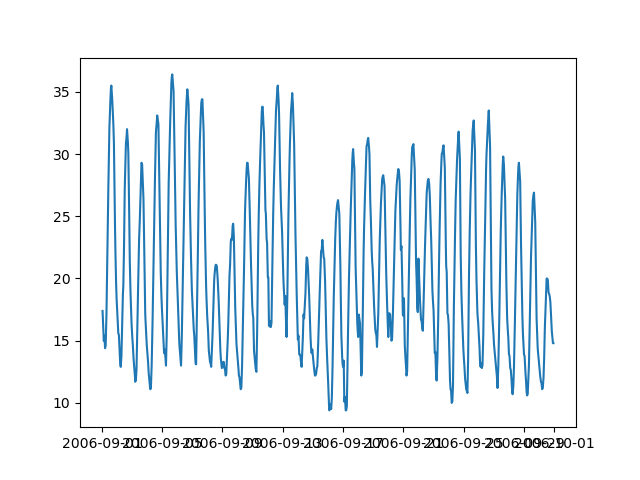

In [19]:
plt.figure()
plt.plot(dataSampled["Dry Bulb Temperature"][1:])

In [20]:
floorTempAdjustment = np.mean([-3.5, -5])
hInterior = np.mean([1, 3])
alphaRoof = np.mean([0.6, 0.9])
windSpeed = np.mean([0, 6])
windSpeed = np.mean([0, 6])
wallRoughness = np.mean([1.11, 2.17])
hExterior = convectionDOE2(np.mean([1, 3]), windSpeed, wallRoughness) #using DOE-2 to calculate this

floor material:
                                              key    Roughness  Thickness  \
index                                                                       
Plywood (Douglas Fir) - 12.7mm           Material       Smooth   0.047148   
I05 154mm batt insulation                Material    VeryRough   0.235741   
F05 Ceiling air space resistance  Material:AirGap          NaN   0.047148   
M15 200mm heavyweight concrete           Material  MediumRough   0.188593   
Soil                                     Material          NaN   0.518630   

                                  Conductivity   Density  Specific_Heat  \
index                                                                     
Plywood (Douglas Fir) - 12.7mm        0.032324   540.000     325.929808   
I05 154mm batt insulation             0.048160    19.000     924.664236   
F05 Ceiling air space resistance      0.261934     1.293    1005.000000   
M15 200mm heavyweight concrete        2.101035  2240.000     969.7085

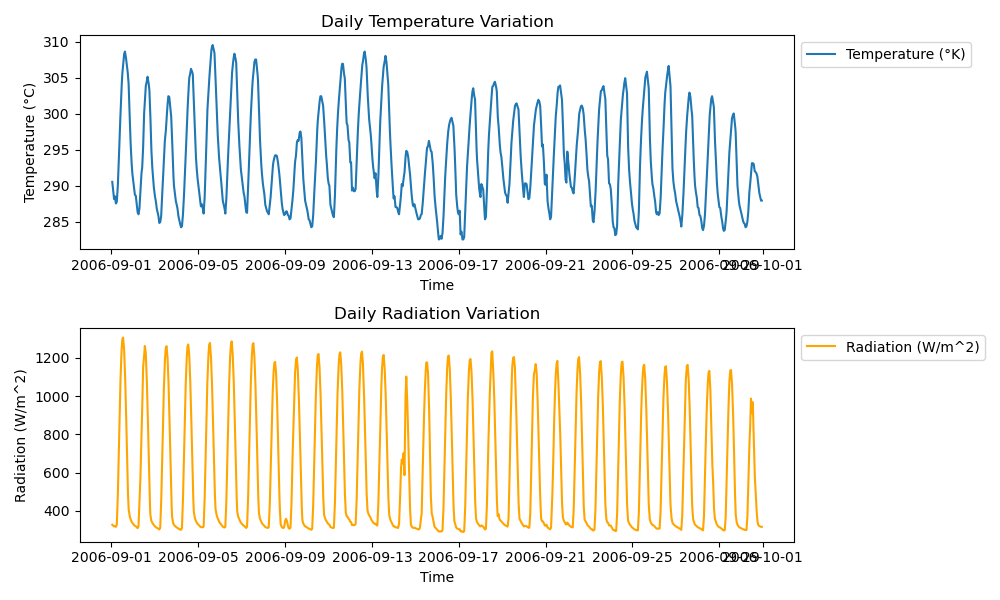

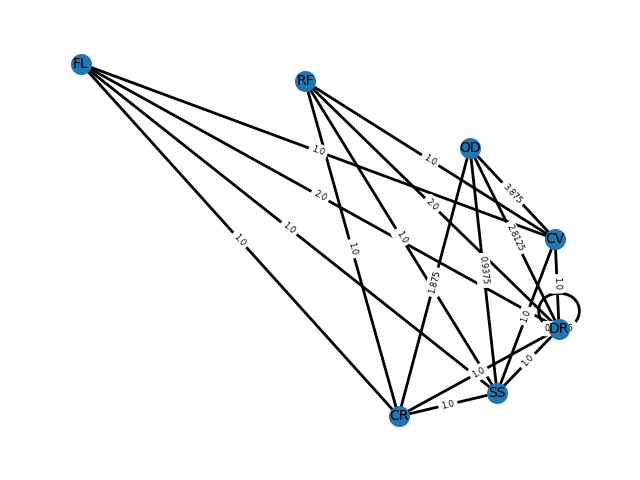

Initializing radiation for CR
Initializing radiation for SS
Initializing radiation for DR
Initializing radiation for CV
Initializing radiation for OD
Initializing radiation for RF
Initializing radiation for FL


/Users/nicholasbachand/Documents/Research/InteriorModeling/myBuilding.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if T <= 0 and i > iVentMin and Tints_avg[i] > coolingThreshold and Tout_mins[day+1] < ventThreshold and h > startVentHour and (T_old > 0 or allVent == True or h in otherVentHours):
/Users/nicholasbachand/Documents/Research/InteriorModeling/myBuilding.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  outputs["WSVent"].append(weather_data["Wind Speed"][i])
/Users/nicholasbachand/Documents/Research/InteriorModeling/myBuilding.py:235: FutureWarning: Series.__getitem__ treating keys as positions 

Ventilation at 20 hours (time: 20)
Ventilation at 23 hours (time: 23)
Ventilation at 20 hours (time: 20)
Ventilation at 20 hours (time: 20)
Ventilation at 23 hours (time: 23)
Ventilation at 20 hours (time: 20)
Ventilation at 23 hours (time: 23)
Ventilation at 19 hours (time: 19)
Ventilation at 23 hours (time: 23)
Ventilation at 21 hours (time: 21)
Ventilation at 23 hours (time: 23)
Ventilation at 20 hours (time: 20)
Ventilation at 23 hours (time: 23)
Ventilation at 19 hours (time: 19)
Ventilation at 23 hours (time: 23)
Ventilation at 19 hours (time: 19)


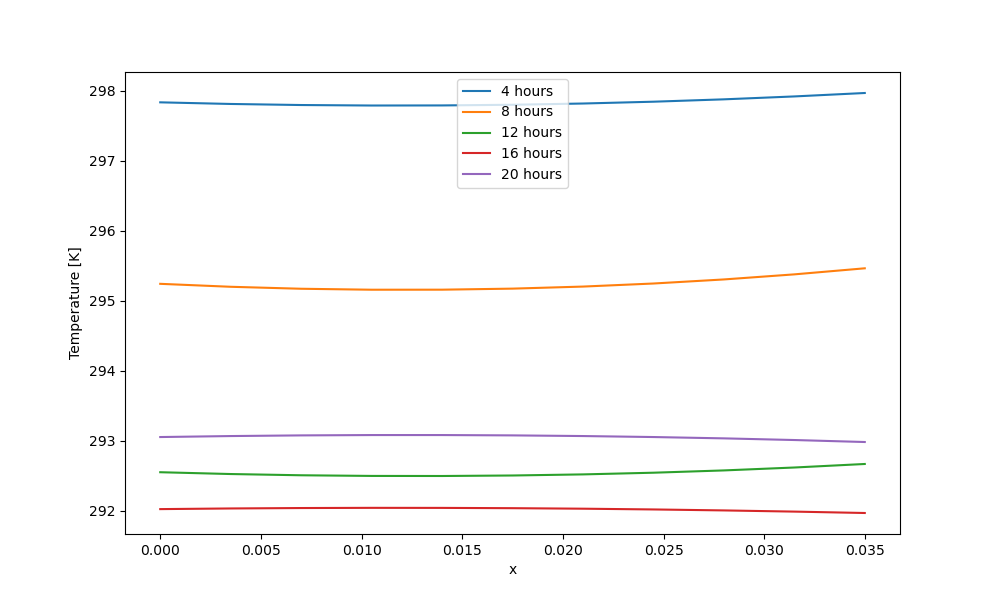

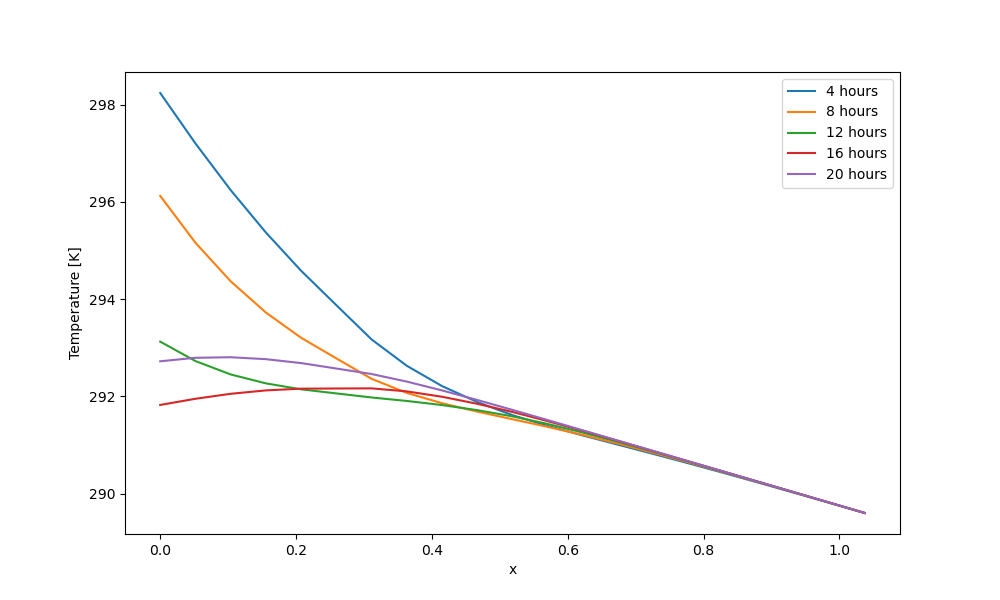

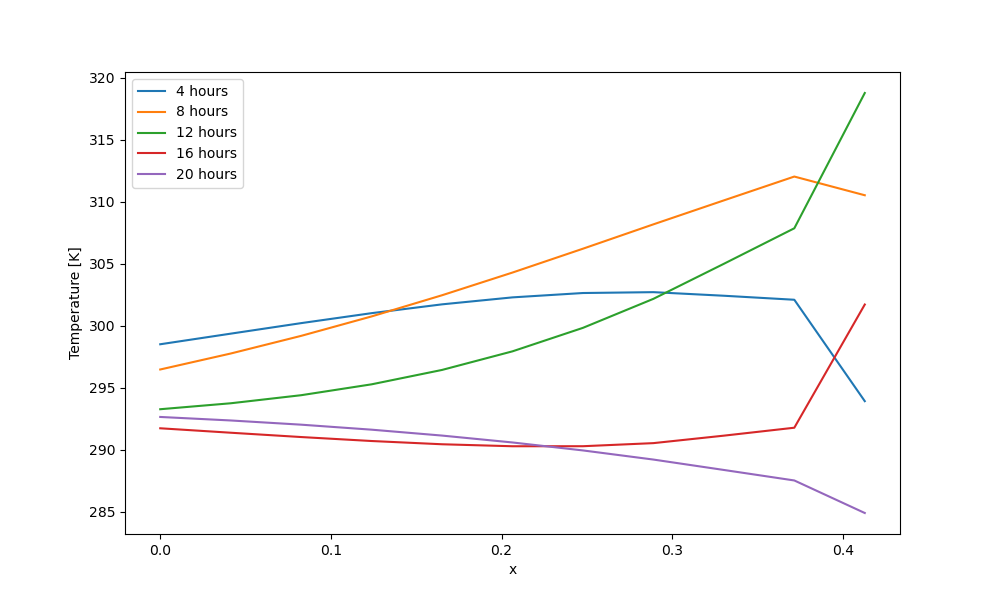

Average "ceiling - floor" temperature difference at ventilation time: [0.29204125 0.1731533  0.2440063  0.28814007 0.18513138 0.27967995
 0.14881115 0.28355829 0.11972896 0.23086569 0.16223264 0.264211
 0.16548842 0.27714458 0.10454131 0.24315101]
Average "outdoor - floor" temperature difference at ventilation time: [ 0.11719133 -6.49242104 -1.52999252  0.11397272 -5.17138168  0.09607466
 -6.48100454  0.10200591 -7.77211993  0.10154823 -1.65108091  0.11287128
 -3.05566792  0.09812526 -9.2415186  -3.77658228]
Average "interior wall - floor" temperature difference at ventilation time: [-0.25058191  0.16602627 -0.24788405 -0.25475784  0.12153609 -0.27101383
  0.1878255  -0.26921447  0.2774942  -0.09867994  0.07502877 -0.14076016
  0.13956687 -0.21462459  0.33916257 -0.24488662]
Average "exterior wall - floor" temperature difference at ventilation time: [ 0.66840766 -0.00943587  0.54456808  0.69721814  0.09527017  0.66426673
 -0.06470295  0.63811171 -0.24471462  0.41947852  0.16028212  0.5

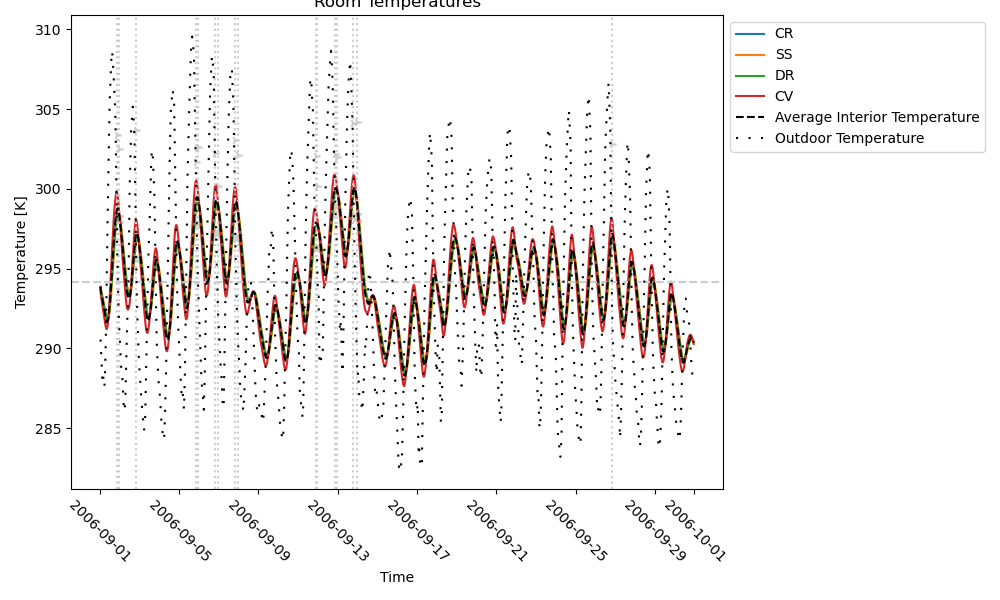

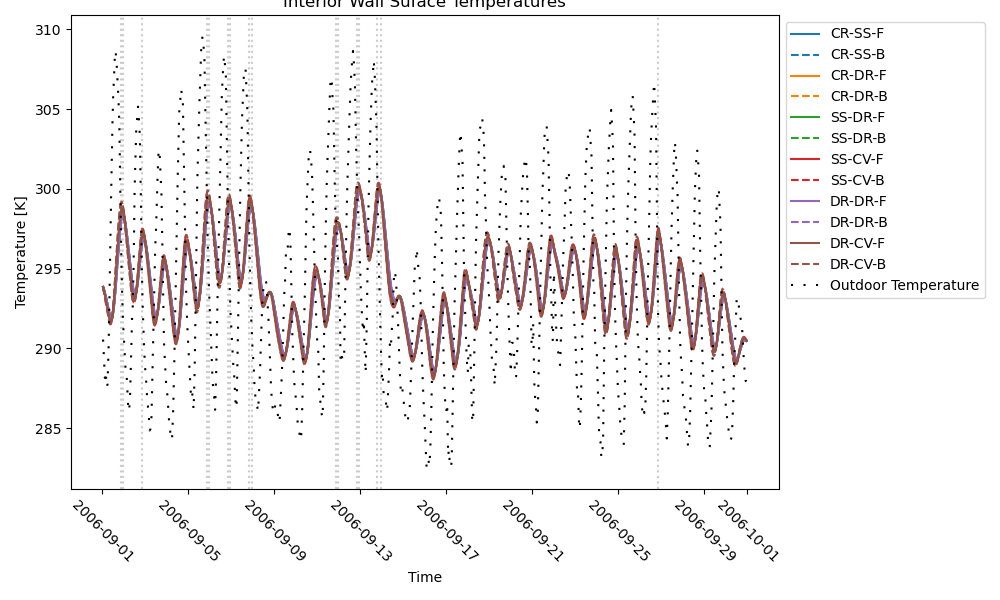

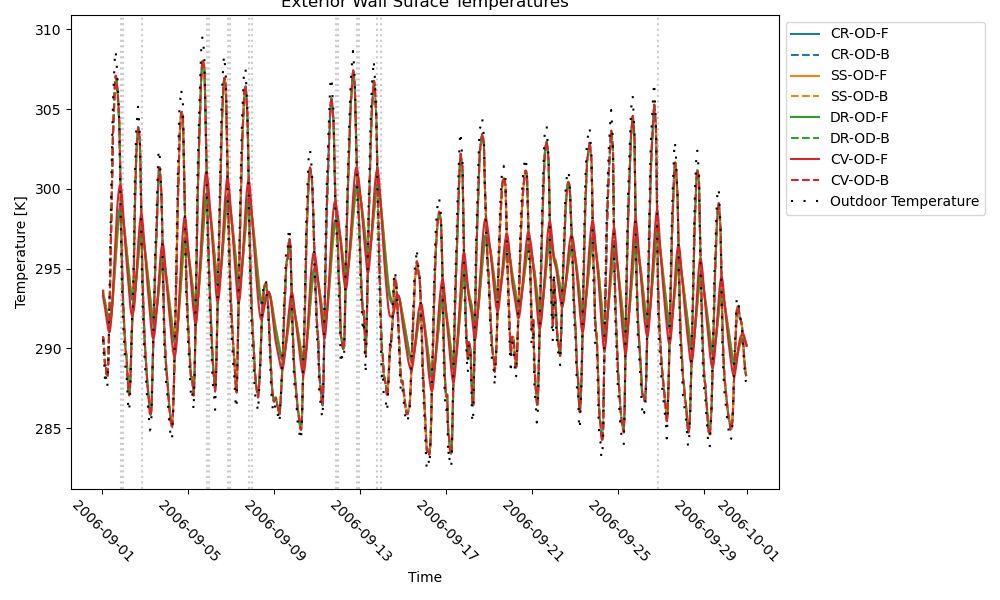

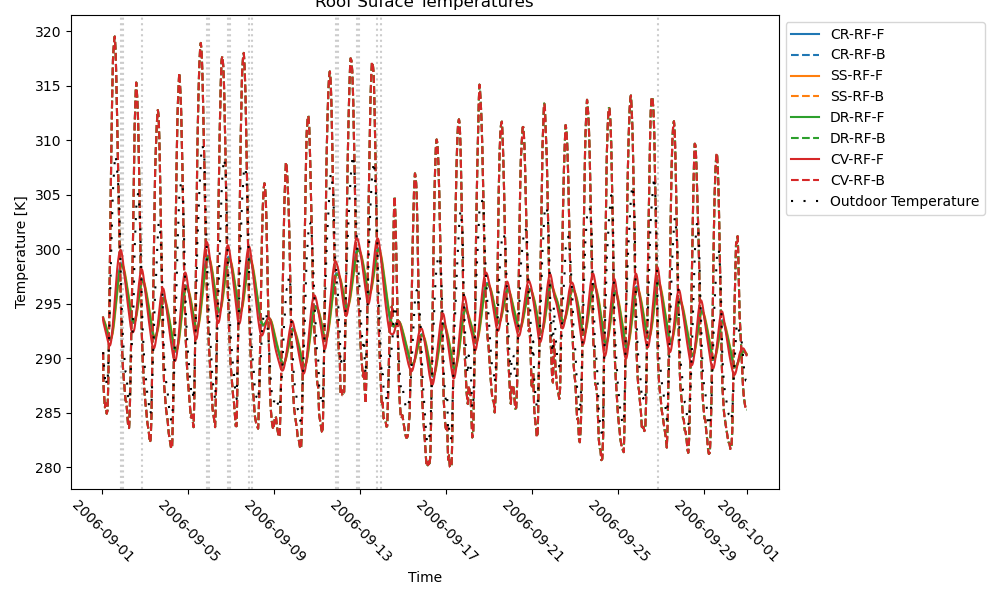

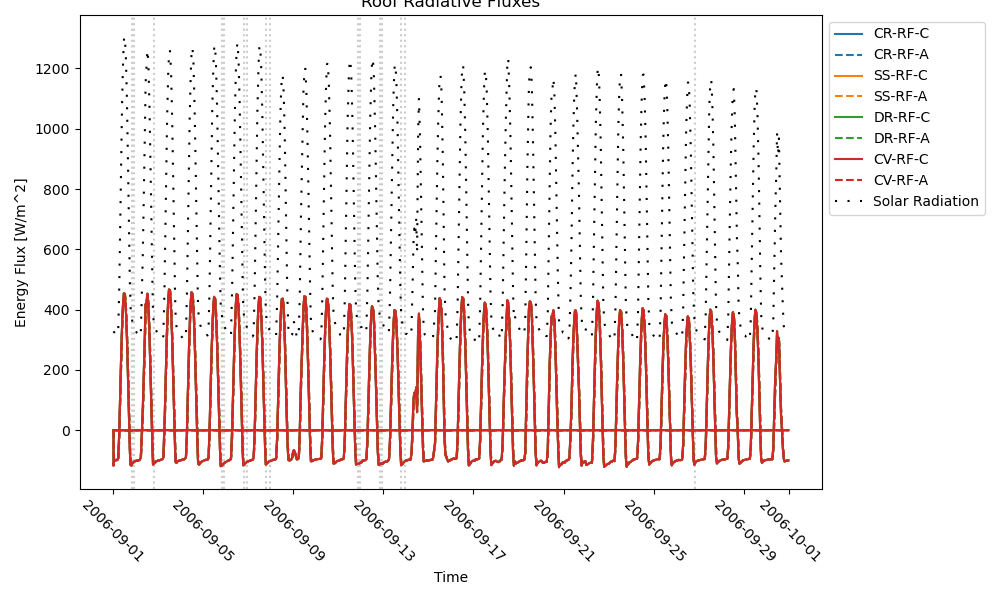

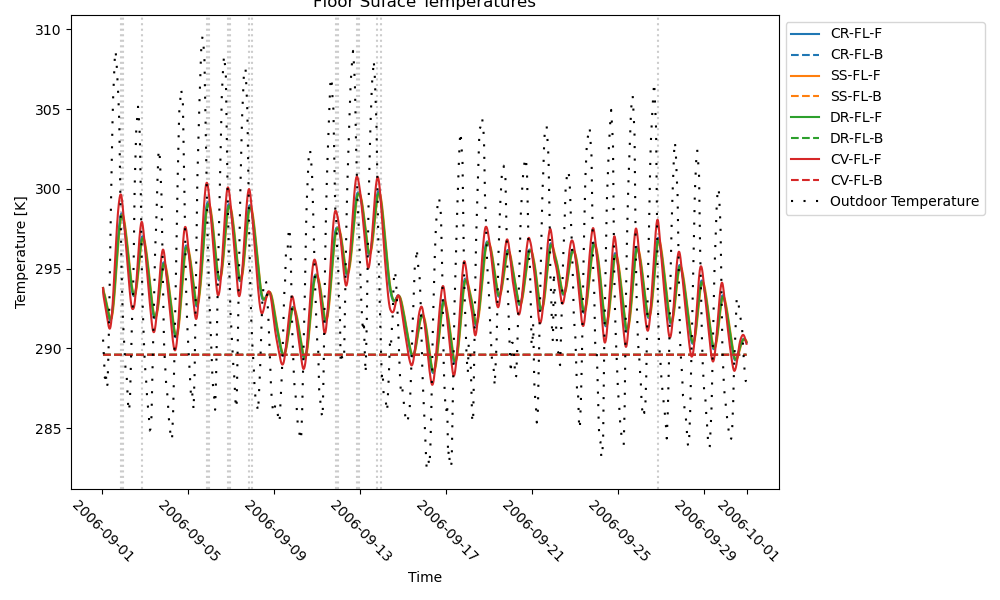

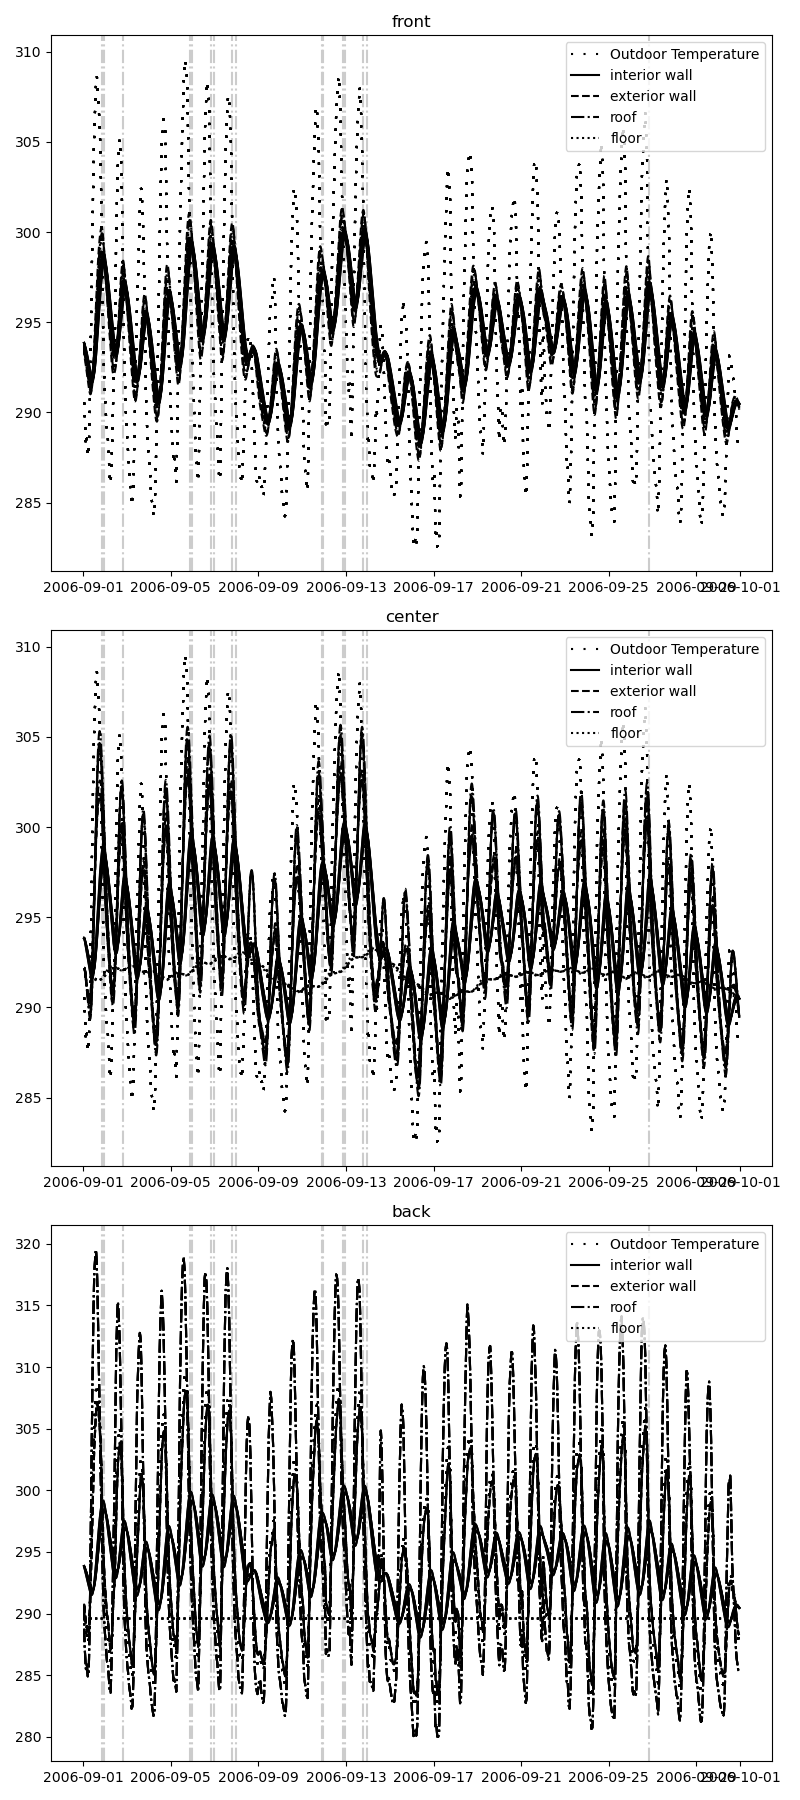

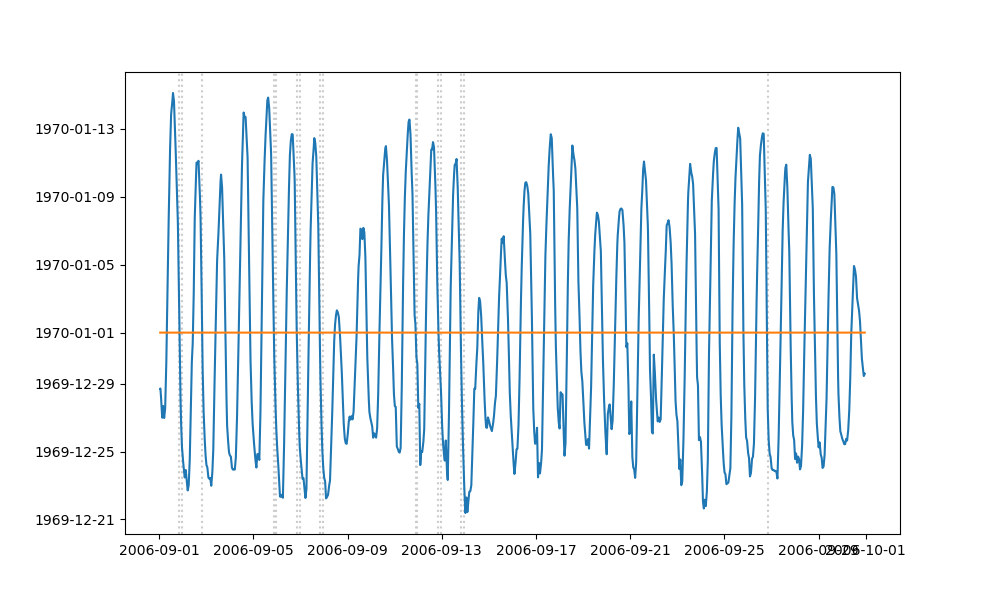

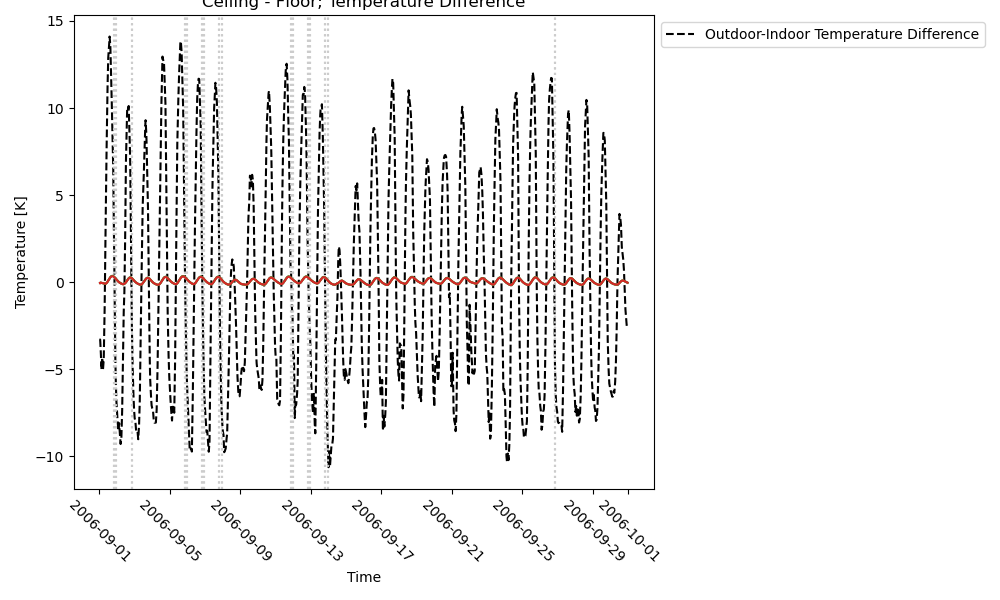

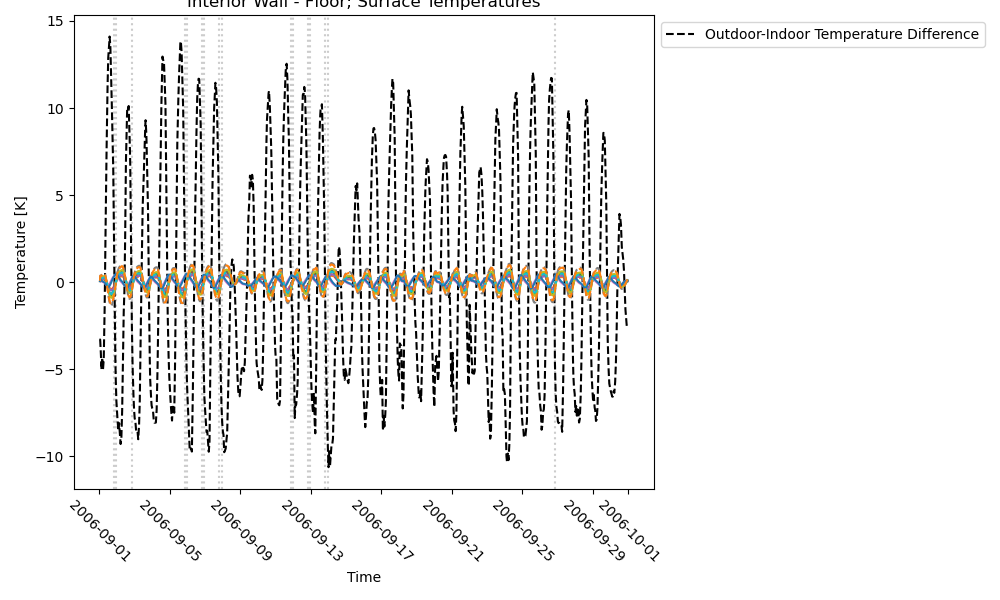

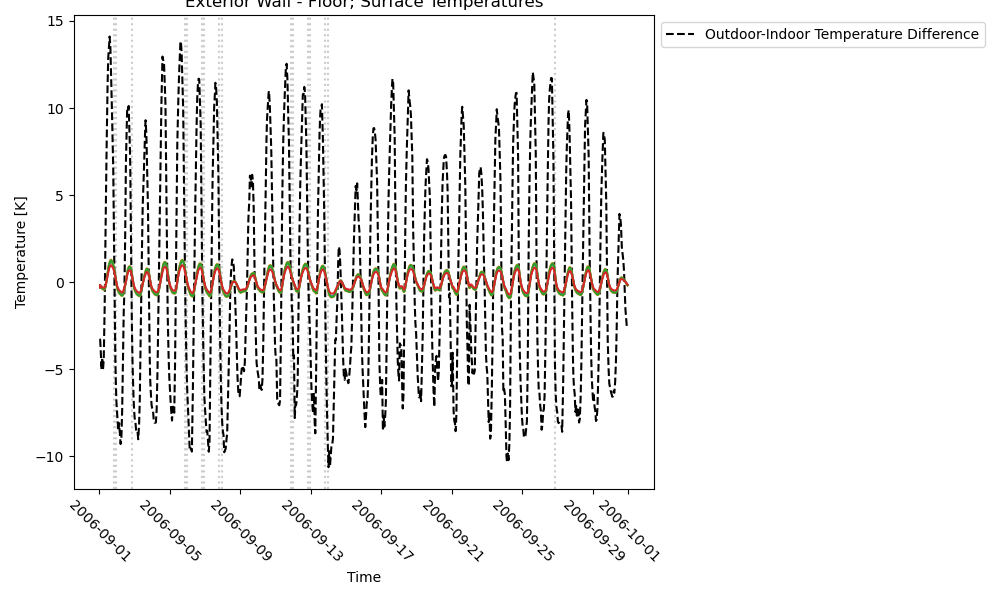

In [21]:
outputsGraphBEM = runMyBEM(
    dataSampled,
    materials,
    floorTempAdjustment,
    hInterior,
    hExterior,
    alphaRoof,
    verbose = True,
    makePlots = True)